# IBM Applied Data Science Capstone - Optimal Location for Opening a Chinese Restaurant in Toronto

1. Introduction: 

    1.1 Background
While opening a restaurant is one of the profitable businesses, wrong location may lead to failure within a year.  Location should be the first consideration before opening a restaurant because it directly determines demand for the restaurant.  
    1.2 Business Problem: 
The objective of this Capstone project is to find an optimal location for opening a Chinese Restaurant in Toronto.  With its high income level, being home to diverse nationalities and many successful businesses, Toronto is where many entrepreneurs are willing to open a restaurant.  With its unique cuisine and tastes, Chinese restaurant is in high demand all over the world, including in Toronto.  So, for this project, we will assume that an entrepreneur plans to open a Chinese restaurant in Toronto.  Our focus is to determine neighborhoods where the demand for Chinese restaurant is the highest.     
    1.3 Target Audience:
The target audience of the project are listed below:
        1.	Local entrepreneurs planning to open a Chinese restaurant in Toronto
        2.	Chinese businessmen planning to open a Chinese restaurant in Toronto
        3.	Chinese restaurant owners willing to open their branch in Toronto
All the stakeholders listed above are interested to find out an optimal neighborhood in Toronto to open their Chinese restaurant.  Choosing a wrong neighborhood means failure of a business for them. This analysis will help them to better understand Toronto neighborhoods and find the best location for their restaurant.  


### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    cer

### Web scraping and building a clean dataframe of Toronto Postal codes

I scraped the following Wikipedia page, “List of Postal code of Canada: M” in order to obtain the data about the Toronto & the Neighborhoods in it.

In [2]:
#column names
column_name = ['PostalCode', 'Borough', 'Neighborhood']
# Wikipedia link of the data
table_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
url_req = requests.get(table_url)
url_req
toronto_postal = pd.read_html(url_req.text, header=0)
toronto_postal = toronto_postal[0]
toronto_postal.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Then I dropped all the rows with missing data.

In [3]:
toronto_postal = toronto_postal[toronto_postal.Borough !='Not assigned']
toronto_postal.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Web scraping and building a clean dataframe of Toronto Neighborhoods Demographics

Demand for Chinese restaurants in Toronto is likely to be more where population size is large, population density and average income are high.  To acquire the indicators above I import “Demographics of Toronto neighborhoods” table from Wikipedia.

In [4]:
# Wikipedia link of the data
table_url2 = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
url_req2 = requests.get(table_url2)
url_req2
toronto_demographics = pd.read_html(url_req2.text, header=0)
toronto_demographics = toronto_demographics[1]
toronto_demographics.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


##### Extract Neighborhood name, Population, Density and Average income of neighborhoods

In [5]:
toronto_demographics=toronto_demographics[['Name','Population', 'Density (people/km2)','Average Income']]
toronto_demographics.head()

,Name,Population,Density (people/km2),Average Income
0,Toronto CMA Average,5113149,866,40704
1,Agincourt,44577,3580,25750
2,Alderwood,11656,2360,35239
3,Alexandra Park,4355,13609,19687
4,Allenby,2513,4333,245592


In [6]:
toronto_demographics.rename(columns={'Name': 'Neighborhood'}, inplace=True)
toronto_demographics.head()

,Neighborhood,Population,Density (people/km2),Average Income
0,Toronto CMA Average,5113149,866,40704
1,Agincourt,44577,3580,25750
2,Alderwood,11656,2360,35239
3,Alexandra Park,4355,13609,19687
4,Allenby,2513,4333,245592


In [8]:
toronto_demographics.shape

(175, 4)

## Get the latitude and the longitude coordinates of each neighborhood

Next step is adding the geographical coordinates to the neighborhoods. To do so I’m extracting geographical data from Geospatial Data csv file.

In [9]:
coordinates = pd.read_csv('https://cocl.us/Geospatial_data')
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
toronto_postal.rename(columns={'Postcode': 'PostalCode'}, inplace=True)
toronto_postal.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


Then I’m combining it with the existing neighborhood dataframe by merging them both based on the postal code.

In [12]:
toronto_postal_coordinates = pd.merge(toronto_postal, coordinates, on='PostalCode', how='inner')
toronto_postal_coordinates.head(10)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
6,M7A,Queen's Park,Not assigned,43.662301,-79.389494
7,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
8,M1B,Scarborough,Rouge,43.806686,-79.194353
9,M1B,Scarborough,Malvern,43.806686,-79.194353


In [13]:
toronto_postal_coordinates.shape

(211, 5)

## Explore, segment, and cluster the neighborhoods in the city of Toronto

Use geopy library to get the latitude and longitude values of Toronto, Canada

In [14]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Create a map of Toronto to visualize the neighbourhoods

In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_postal_coordinates['Latitude'], toronto_postal_coordinates['Longitude'], toronto_postal_coordinates['Borough'], toronto_postal_coordinates['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [17]:
CLIENT_ID = 'QFDBH0QWL5SJ0CANQ5L13WNL41R5NFE2FTGZOK1AIUGD122H' # my Foursquare ID
CLIENT_SECRET = 'GR03DKEJ0R1MTLJVEH5VKYZNZFVBI1EKZGSOWS3EKVIKZMJP' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QFDBH0QWL5SJ0CANQ5L13WNL41R5NFE2FTGZOK1AIUGD122H
CLIENT_SECRET:GR03DKEJ0R1MTLJVEH5VKYZNZFVBI1EKZGSOWS3EKVIKZMJP


In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=QFDBH0QWL5SJ0CANQ5L13WNL41R5NFE2FTGZOK1AIUGD122H&client_secret=GR03DKEJ0R1MTLJVEH5VKYZNZFVBI1EKZGSOWS3EKVIKZMJP&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dc7d5bccad1b600396485b8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 80,
  'suggestedBounds': {'ne': {'lat': 43.6584630045, 'lng': -79.38099903084075},
   'sw': {'lat': 43.649462995499995, 'lng': -79.39341496915925}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Export category of each venue

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Cafe Plenty,Café,43.654571,-79.389450
3,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
4,Rolltation,Japanese Restaurant,43.654918,-79.387424


### Explore Neighborhoods in Toronto


Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues = getNearbyVenues(names=toronto_postal_coordinates['Neighbourhood'],
                                   latitudes=toronto_postal_coordinates['Latitude'],
                                   longitudes=toronto_postal_coordinates['Longitude']
                                  )


Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Not assigned
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

In [25]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [26]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
Agincourt North,2,2,2,2,2,2
Albion Gardens,7,7,7,7,7,7
Alderwood,9,9,9,9,9,9
Bathurst Manor,19,19,19,19,19,19
Bathurst Quay,15,15,15,15,15,15
Bayview Village,4,4,4,4,4,4
Beaumond Heights,7,7,7,7,7,7


In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [28]:
toronto_onehot.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Adelaide,0,0,0,0,0,0,0,0,0,3,0,0,1,0,3,0,0,0,0,0,0,3,

In [30]:
toronto_chinese_restaurant = toronto_grouped[['Neighborhood','Chinese Restaurant']]
toronto_chinese_restaurant.head(10)

,Neighborhood,Chinese Restaurant
0,Adelaide,0
1,Agincourt,0
2,Agincourt North,0
3,Albion Gardens,0
4,Alderwood,0
5,Bathurst Manor,1
6,Bathurst Quay,0
7,Bayview Village,1
8,Beaumond Heights,0
9,Bedford Park,0


In [50]:
toronto_chinese_restaurant_sorted= toronto_chinese_restaurant.sort_values(by='Chinese Restaurant', ascending=False)
toronto_chinese_restaurant_sorted_top = toronto_chinese_restaurant_sorted.head(10)
toronto_chinese_restaurant_sorted_top

,Neighborhood,Chinese Restaurant
22,Chinatown,4
85,Kensington Market,4
62,Grange Park,4
93,L'Amoreaux West,2
21,Central Bay Street,2
182,Toronto Islands,1
24,Church and Wellesley,1
79,Ionview,1
26,Clarks Corners,1
186,University of Toronto,1


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

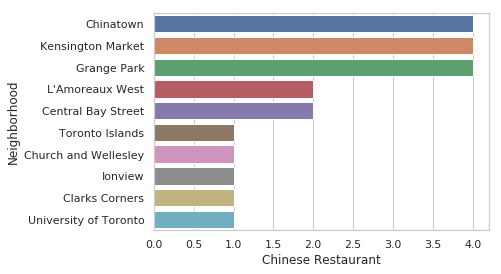

In [52]:
sns.set(style="whitegrid")
ax = sns.barplot(y="Neighborhood", x="Chinese Restaurant", data=toronto_chinese_restaurant_sorted_top)

In [53]:
toronto_postal_coordinates.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
toronto_postal_coordinates.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [54]:
toronto_merged2 = pd.merge(toronto_chinese_restaurant, toronto_postal_coordinates, on='Neighborhood', how='inner')
toronto_merged2.head(10)

,Neighborhood,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
0,Adelaide,0,M5H,Downtown Toronto,43.650571,-79.384568
1,Agincourt,0,M1S,Scarborough,43.794200,-79.262029
2,Agincourt North,0,M1V,Scarborough,43.815252,-79.284577
3,Albion Gardens,0,M9V,Etobicoke,43.739416,-79.588437
4,Alderwood,0,M8W,Etobicoke,43.602414,-79.543484
5,Bathurst Manor,1,M3H,North York,43.754328,-79.442259
6,Bathurst Quay,0,M5V,Downtown Toronto,43.628947,-79.394420
7,Bayview Village,1,M2K,North York,43.786947,-79.385975
8,Beaumond Heights,0,M9V,Etobicoke,43.739416,-79.588437
9,Bedford Park,0,M5M,North York,43.733283,-79.419750


In [55]:
toronto_merged2.shape

(209, 6)

In [56]:
toronto_demographics.head()

,Neighborhood,Population,Density (people/km2),Average Income
0,Toronto CMA Average,5113149,866,40704
1,Agincourt,44577,3580,25750
2,Alderwood,11656,2360,35239
3,Alexandra Park,4355,13609,19687
4,Allenby,2513,4333,245592


In [57]:
toronto_merged3 = pd.merge(toronto_merged2, toronto_demographics, on='Neighborhood', how='inner')
toronto_merged3.head()

,Neighborhood,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude,Population,Density (people/km2),Average Income
0,Agincourt,0,M1S,Scarborough,43.794200,-79.262029,44577,3580,25750
1,Alderwood,0,M8W,Etobicoke,43.602414,-79.543484,11656,2360,35239
2,Bathurst Manor,1,M3H,North York,43.754328,-79.442259,14945,3187,34169
3,Bayview Village,1,M2K,North York,43.786947,-79.385975,12280,2966,46752
4,Bedford Park,0,M5M,North York,43.733283,-79.419750,13749,6057,80827


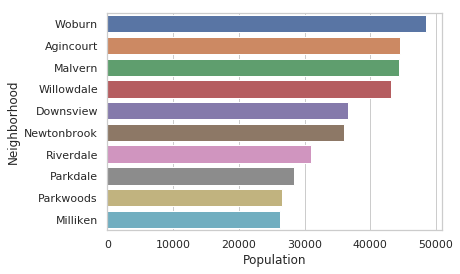

In [59]:
td_sorted_population = toronto_merged3.sort_values(by='Population', ascending=False)
td_sorted_population_top = td_sorted_population.head(10)
ax = sns.barplot(y="Neighborhood", x="Population", data=td_sorted_population_top)

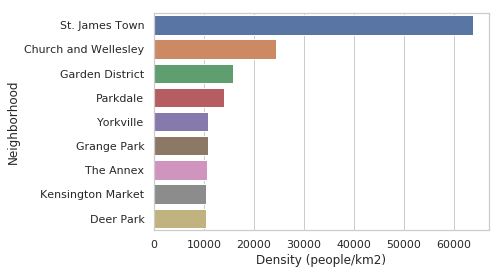

In [62]:
td_sorted_density = toronto_merged3.sort_values(by='Density (people/km2)', ascending=False)
td_sorted_density_top = td_sorted_density.head(10)
ax = sns.barplot(y="Neighborhood", x="Density (people/km2)", data=td_sorted_density_top)

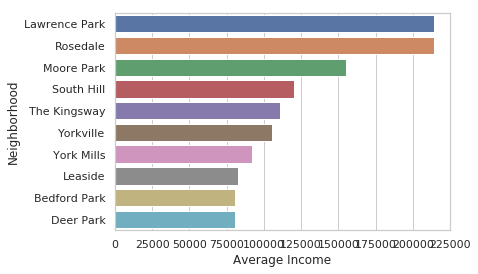

In [64]:
td_sorted_income = toronto_merged3.sort_values(by='Average Income', ascending=False)
td_sorted_income_top = td_sorted_income.head(10)
ax = sns.barplot(y="Neighborhood", x="Average Income", data=td_sorted_income_top)

In [66]:
toronto_cluster = pd.merge(toronto_demographics, toronto_chinese_restaurant, on='Neighborhood', how='inner')
toronto_cluster.head()

,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant
0,Agincourt,44577,3580,25750,0
1,Alderwood,11656,2360,35239,0
2,Bathurst Manor,14945,3187,34169,1
3,Bayview Village,12280,2966,46752,1
4,Bedford Park,13749,6057,80827,0


### Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [67]:
# set number of clusters
kclusters = 5

toronto_clustering = toronto_cluster.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 0, 4, 2, 4, 0, 4, 0, 0], dtype=int32)

In [68]:
# add clustering labels
toronto_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_final = toronto_cluster

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_final = pd.merge(toronto_final, toronto_postal_coordinates, on='Neighborhood', how ='inner')

toronto_final.head() # check the last columns!

,Cluster Labels,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
0,3,Agincourt,44577,3580,25750,0,M1S,Scarborough,43.794200,-79.262029
1,0,Alderwood,11656,2360,35239,0,M8W,Etobicoke,43.602414,-79.543484
2,0,Bathurst Manor,14945,3187,34169,1,M3H,North York,43.754328,-79.442259
3,4,Bayview Village,12280,2966,46752,1,M2K,North York,43.786947,-79.385975
4,2,Bedford Park,13749,6057,80827,0,M5M,North York,43.733283,-79.419750


In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_final['Latitude'], toronto_final['Longitude'], toronto_final['Neighborhood'], toronto_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [70]:
toronto_final.loc[toronto_final['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
1,0,Alderwood,11656,2360,35239,0,M8W,Etobicoke,43.602414,-79.543484
2,0,Bathurst Manor,14945,3187,34169,1,M3H,North York,43.754328,-79.442259
6,0,Brockton,9039,8217,27260,0,M6K,West Toronto,43.636847,-79.428191
8,0,Church and Wellesley,13397,24358,37653,1,M4Y,Downtown Toronto,43.665860,-79.383160
9,0,Clairlea,11104,3102,33392,0,M1L,Scarborough,43.711112,-79.284577
10,0,Cliffcrest,14531,2073,38182,0,M1M,Scarborough,43.716316,-79.239476
11,0,Cliffside,9386,3831,32701,0,M1M,Scarborough,43.716316,-79.239476
14,0,Dorset Park,14189,3331,26525,1,M1P,Scarborough,43.757410,-79.273304
16,0,Eringate,8008,3282,34789,0,M9C,Etobicoke,43.643515,-79.577201
17,0,Flemingdon Park,21287,8760,23471,1,M3C,North York,43.725900,-79.340923


#### Cluster 2

In [71]:
toronto_final.loc[toronto_final['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
31,1,Lawrence Park,6653,1828,214110,0,M4N,Central Toronto,43.728020,-79.388790
39,1,Moore Park,4474,3959,154825,0,M4T,Central Toronto,43.689574,-79.383160
51,1,Rosedale,7672,2821,213941,0,M4W,Downtown Toronto,43.679563,-79.377529


#### Cluster 3

In [72]:
toronto_final.loc[toronto_final['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
4,2,Bedford Park,13749,6057,80827,0,M5M,North York,43.733283,-79.419750
13,2,Deer Park,15165,10387,80704,0,M4V,Central Toronto,43.686412,-79.400049
32,2,Leaside,13876,4938,82670,0,M4G,East York,43.709060,-79.363452
48,2,Princess Gardens,9288,2249,80607,0,M9B,Etobicoke,43.650943,-79.554724
58,2,South Hill,6218,4935,120453,0,M4V,Central Toronto,43.686412,-79.400049
65,2,The Kingsway,8780,3403,110944,0,M8X,Etobicoke,43.653654,-79.506944
78,2,York Mills,17564,2409,92099,0,M2L,North York,43.757490,-79.374714
79,2,Yorkville,6045,10795,105239,0,M5R,Central Toronto,43.672710,-79.405678


#### Cluster 4

In [73]:
toronto_final.loc[toronto_final['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
0,3,Agincourt,44577,3580,25750,0,M1S,Scarborough,43.794200,-79.262029
15,3,Downsview,36613,2270,26751,0,M6L,North York,43.713756,-79.490074
35,3,Malvern,44324,5003,25677,0,M1B,Scarborough,43.806686,-79.194353
38,3,Milliken,26272,3654,25243,0,M1V,Scarborough,43.815252,-79.284577
43,3,Newtonbrook,36046,4110,33428,0,M2M,North York,43.789053,-79.408493
45,3,Parkdale,28367,13974,26314,0,M6R,West Toronto,43.648960,-79.456325
46,3,Parkwoods,26533,5349,34811,0,M3A,North York,43.753259,-79.329656
49,3,Riverdale,31007,7771,40139,0,M4K,East Toronto,43.679557,-79.352188
59,3,St. James Town,14666,63765,22341,1,M5C,Downtown Toronto,43.651494,-79.375418
60,3,St. James Town,14666,63765,22341,1,M4X,Downtown Toronto,43.667967,-79.367675


#### Cluster 5

In [74]:
toronto_final.loc[toronto_final['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,Population,Density (people/km2),Average Income,Chinese Restaurant,PostalCode,Borough,Latitude,Longitude
3,4,Bayview Village,12280,2966,46752,1,M2K,North York,43.786947,-79.385975
5,4,Birch Cliff,12266,3525,48965,0,M1N,Scarborough,43.692657,-79.264848
7,4,Cabbagetown,11120,7943,50398,1,M4X,Downtown Toronto,43.667967,-79.367675
12,4,Davisville,23727,7556,55735,0,M4S,Central Toronto,43.704324,-79.388790
20,4,Guildwood,12820,2688,40806,0,M1E,Scarborough,43.763573,-79.188711
21,4,Henry Farm,2790,3066,56395,1,M2J,North York,43.778517,-79.346556
36,4,Markland Wood,10240,3507,51695,0,M9C,Etobicoke,43.643515,-79.577201
47,4,Port Union,12450,2310,48117,0,M1C,Scarborough,43.784535,-79.160497
50,4,Roncesvalles,15996,8079,46820,0,M6R,West Toronto,43.648960,-79.456325
54,4,Runnymede,4382,5155,42635,0,M6N,York,43.673185,-79.487262


 It is recommended to open Chinese restaurant in neighborhoods of Cluster 2.  First, neighborhoods of Cluster 2 is the only neighborhood with all 6 digit avergage income.  Additionally, there are no Chinese restaurants in those neighborhoods meaning that we will not suffer comptetition in these neighborhoods.  Moreover, population density is relatively high in these neighborhoods.  All the factors listed above shows that neighborhoods of Cluster 2 to name Lawrence Park, Moore Park and Rosedale are ideal neighborhoods to open a Chinese restaurant in Toronto.  